In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pathlib import Path

import math
from __future__ import division
import copy


import torch
import torch.utils.data
import torch.nn as nn
from torch import distributions, nn, optim
from torchvision import transforms, datasets
from scipy.stats import multivariate_normal
import scipy.stats as stats
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
import pandas as pd

#JITTER = 1e-2

%matplotlib inline
torch.set_default_dtype(torch.float64)

In [2]:
mean = torch.tensor([0.,0.])
int(mean.shape[0])

2

In [30]:
# Miscellaneous colour map definitions for visualising different contour plots at the same time

cmap1 = ['lightsalmon', 'navy', 'darkorchid', 'mediumvioletred', 'crimson', 'tomato']
cmap2 = ['teal', 'forestgreen', 'limegreen', 'mediumspringgreen', 'aquamarine', 'mediumturquoise']
cmap3 = ['palevioletred', 'navy', 'darkorchid', 'mediumvioletred', 'crimson', 'tomato', 'lightsalmon']


def homogeneous_split(data, partitions, seed=42):
    rng = np.random.default_rng(seed)
    perm = rng.permutation(len(data))
    
    client_data = []
    for i in range(partitions):
        client_idx = perm[i::partitions]
        client_data.append(data[client_idx])
    
    return client_data

def batch(data, length):
    assert length > 0, "Can't use batch of size 0"
    rng = np.random.default_rng()
    perm = rng.permutation(len(data))
    idx_0 = perm[0]
    batch = torch.atleast_2d(data[idx_0])
    for i in range(1, length):
        client_idx = perm[i]
        samp = torch.atleast_2d(data[client_idx])
        batch = torch.cat((batch, samp), 0)
    return batch

def heterogeneous_split(data, partitions):
    
    l = len(data)
    weights = []
    for i in range(partitions-1):
        w_i = torch.distributions.uniform.Uniform(torch.tensor([1.]), (l-partitions+i+(1+1e-5))).sample()
        w = torch.floor(w_i)
        weights.append(w.numpy())
        l -= w
    weights.append(l.numpy())
    
    client_data = []
    counter = 0
    for w in weights:
        client_x_n = data[counter:int(counter+w[0])]
        client_data.append(client_x_n)
        counter += w[0]
        counter = int(counter)
        
    return client_data
    
def plot_training(training_array):
    x_vals = np.arange(1, len(training_array)+1)
    plt.figure()
    plt.grid(visible=True)
    plt.plot(x_vals, training_array)
    plt.ylabel('ELBO Loss')
    plt.xlabel('Step')
    plt.show()

In [5]:
class Gaussian:
    #Change to log sum exp instead of explicitly evaluating this
    
    def Gaussian(mean, cov, theta):
        assert cov.shape[0] > 0, "Dimensionality specified incorrectly"
        if cov.shape[0] == 1:
            return torch.exp(-(((theta - mean) ** 2)/(2 * cov))) / ((torch.abs(2 * cov * np.pi)) ** 0.5)
        else:
            assert mean.shape[0] == cov.shape[1], "Not the same dimension, multiplication not possible"

            vector = theta-mean
            vector.unsqueeze(-1)

            # (\theta - mean)^T \Sigma ^ {-1} (\theta - mean)        
            part = torch.matmul(vector.unsqueeze(0), torch.linalg.solve(cov, vector.unsqueeze(-1)))

            det = torch.linalg.det(cov) ** 0.5

            coef_ = det * ((np.pi * 2) ** (cov.shape[0] / 2))
            
            coef = coef_ ** -1

            return (coef * torch.exp(- part / 2)).squeeze()
        
    def SphericalGaussian(mean, cov, theta, D):
        assert D > 0, "Negative dimension in spherical Gaussian"
        if D == 1:
            return torch.exp(-(((theta - mean) ** 2)/(2 * cov))) / ((torch.abs(2 * cov * np.pi)) ** 0.5)
        else:
            vector = theta-mean
            vector.unsqueeze(-1)

            # (\theta - mean)^T \Sigma ^ {-1} (\theta - mean)        
            part = torch.matmul(vector.unsqueeze(0), vector.unsqueeze(-1)) / cov

            coef_ = torch.pow(torch.abs(cov * np.pi * 2), (D / 2))

            coef = coef_ ** -1

            return (coef * torch.exp(- part / 2)).squeeze()
            
    def GaussianMixture(mean_list, cov_list, theta, parameters, D=None):
        ret = 0.
        assert len(mean_list) == len(parameters), "Different list lengths"
        assert len(mean_list) == len(cov_list), "Different list lengths"
        
        param = 0.
        for w in parameters:
            param += w
            
        if param != 1:
            for k in range(len(parameters)):
                w = parameters[k]
                parameters[k] = w / param
        if D is None:      
            for i in range(len(parameters)):
                ret += parameters[i] * Gaussian.Gaussian(mean_list[i], cov_list[i], theta)
        else:
            for i in range(len(parameters)):
                ret += parameters[i] * Gaussian.SphericalGaussian(mean_list[i], cov_list[i], theta, D)
            
        return ret
    
    def SampleFromMixture(mean_list, cov_list, parameters, num_samples):
        
        param = 0.
        for w in parameters:
            param += w
            
        if param != 1:
            for k in range(len(parameters)):
                w = parameters[k]
                parameters[k] = w / param
        
        sample_nums = torch.distributions.multinomial.Multinomial(num_samples, 
                                                                           parameters).sample()
        component_sample_num = sample_nums.numpy()
        samples = torch.tensor([])
        
        for i in range(len(parameters)):
            if cov_list[i].shape[0] > 1:    
                m_i = torch.distributions.multivariate_normal.MultivariateNormal(mean_list[i],
                                                                                 covariance_matrix=cov_list[i])
            else:
                m_i = torch.distributions.normal.Normal(mean_list[i],cov_list[i])
            
            sample = m_i.sample((int(component_sample_num[i]),))
            samples = torch.cat((samples, sample), 0)
                
        return samples
    
    def HeterogenousSampleMix(mean_list, cov_list, parameters, num_samples):
        
        param = 0.
        for w in parameters:
            param += w
            
        if param != 1:
            for k in range(len(parameters)):
                w = parameters[k]
                parameters[k] = w / param
        
        sample_nums = torch.distributions.multinomial.Multinomial(num_samples, 
                                                                           parameters).sample()
        component_sample_num = sample_nums.numpy()
        
        client_data =[]
        for i in range(len(parameters)):
            if cov_list[i].shape[0] > 1:    
                m_i = torch.distributions.multivariate_normal.MultivariateNormal(mean_list[i],
                                                                                 covariance_matrix=cov_list[i])
            else:
                m_i = torch.distributions.normal.Normal(mean_list[i],cov_list[i])
            
            sample = m_i.sample((int(component_sample_num[i]),))
            client_data.append(sample)
                
        return client_data

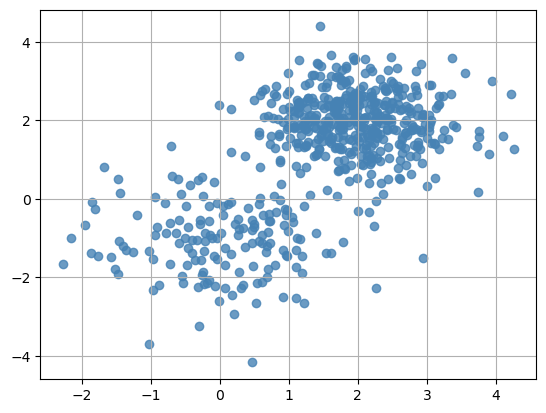

In [6]:
#Defining the model and sampling data points

mean_1_n = torch.tensor([2.,2.])
var_1_n = 0.5*torch.eye(2)
mean_2_n = torch.tensor([0.,-1.])
var_2_n = torch.eye(2)
w_n = 0.25

samples_n = Gaussian.SampleFromMixture([mean_1_n,mean_2_n], [var_1_n,var_2_n], torch.tensor([.75,0.25]), 600)


x = y = np.linspace(0,4)
X_, Y_ = np.meshgrid(x, y)


#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(samples_n[:,0], samples_n[:,1], c="steelblue", alpha=.8)
plt.grid(visible=True)

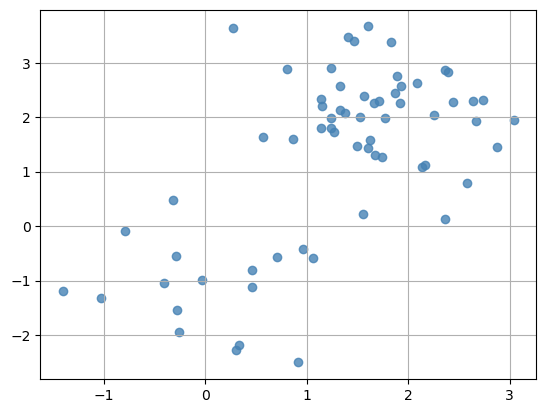

In [7]:
batch = batch(samples_n, 64)
plt.scatter(batch[:,0], batch[:,1], c="steelblue", alpha=.8)
plt.grid(visible=True)

In [8]:
def MaximumLikelihoodEstimator(data, client, true_mean, w):
    d = int(client["mean"].shape[0])
    total = torch.zeros(d)
    n = len(data)
    mean_list = [true_mean, client["noise_m"]]
    cov_list = [client["true_v"], client["noise_v"]]
    ws = [1-w, w]
    for datapoint in data:
        total -= Gaussian.GaussianMixture(mean_list, cov_list, datapoint, ws, D=d).log()
    
    return total / n

In [9]:
client = {
    "mean": torch.tensor([0.,0.]),
    "noise_m": torch.tensor([0.,-1.]),
    "true_v": torch.tensor([.5]),
    "noise_v": torch.tensor([1.])
}


In [10]:
MaximumLikelihoodEstimator(samples_n, client, mean_1_n, w_n)

tensor([2.8426, 2.8426])

In [11]:
  
heterogeneous_split(samples_n, 5)


[tensor([[ 1.6434,  1.8827],
         [ 1.3261,  3.0668],
         [ 2.2499,  2.5795],
         [ 2.7657,  2.3483],
         [ 2.8095,  2.7061],
         [ 0.4998,  0.5989],
         [ 2.3866,  1.7696],
         [ 1.2508,  2.8235],
         [ 1.2864,  1.9486],
         [ 3.1972,  1.8775],
         [ 1.3785,  2.7897],
         [ 0.7920,  1.3999],
         [ 2.0553,  2.2193],
         [ 3.2570,  2.8624],
         [ 1.8782,  2.1774],
         [ 0.7749,  1.1467],
         [ 0.8627,  3.1229],
         [ 2.9131,  2.1971],
         [ 3.1619,  1.2494],
         [ 0.7994,  1.4345],
         [ 1.5284,  0.0218],
         [ 2.7826,  1.9583],
         [ 1.9858,  2.4809],
         [ 1.9263,  3.8246],
         [ 2.6183,  1.9653],
         [ 1.9867,  2.2017],
         [ 2.3263,  1.1233],
         [ 1.8830,  1.3664],
         [ 2.3703,  3.9204],
         [ 1.4439,  2.4078],
         [ 1.6788,  2.8598],
         [ 2.2215,  2.9400],
         [ 0.1103,  2.0598],
         [ 1.8549,  1.6025],
         [ 1.5

In [12]:
# Miscellaneous colour map definitions for visualising different contour plots at the same time

cmap1 = ['lightsalmon', 'navy', 'darkorchid', 'mediumvioletred', 'crimson', 'tomato']
cmap2 = ['teal', 'forestgreen', 'limegreen', 'mediumspringgreen', 'aquamarine', 'mediumturquoise']
cmap3 = ['palevioletred', 'navy', 'darkorchid', 'mediumvioletred', 'crimson', 'tomato', 'lightsalmon']


In [13]:
def Normal(mean, cov_coef, x, D):
    assert D > 0, "negative dimensional data"
    if D > 2:
        s = np.dot((x-mean),(x-mean))
    elif D == 2:
        if torch.is_tensor(x):
            x = x.squeeze(0).numpy()
        s = (x[0] - mean[0]) ** 2 + (x[1] - mean[1]) ** 2
    else:
        s = (x-mean) ** 2
    return np.exp(-(s/(2 * cov_coef))) / ((np.absolute(2 * cov_coef * np.pi)) ** (D/2))

In [14]:
def Mixture(x, w, mean_1, cov_coef_1, mean_2, cov_coef_2, D):
    return (1 - w) * Normal(mean_1, cov_coef_1, x, D) + w * Normal(mean_2, cov_coef_2, x, D)

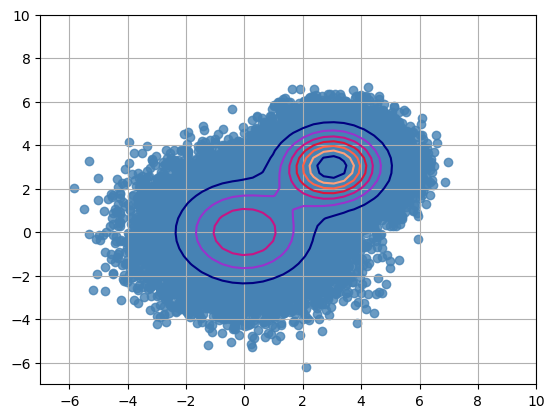

In [19]:
#Defining the model and sampling data points
D = 2

mean_1_mult3 = 3.*torch.ones(D)
var_1_mult3 = torch.eye(D)
mean_2_mult3 = torch.zeros(D)
var_2_mult3 = 2*torch.eye(D)
w_mult = 0.5
num_clients = 100

samples_large = Gaussian.SampleFromMixture([mean_1_mult3,mean_2_mult3], [var_1_mult3,var_2_mult3], torch.tensor([.5,.5]), 60_000)
cli_samples = homogeneous_split(samples_large, num_clients)

x = y = np.linspace(-7,10)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0.5, [3.,3.], 1, [0.,0.], 2., 2)

plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(samples_large[:,0], samples_large[:,1], c="steelblue", alpha=.8)
plt.grid(visible=True)

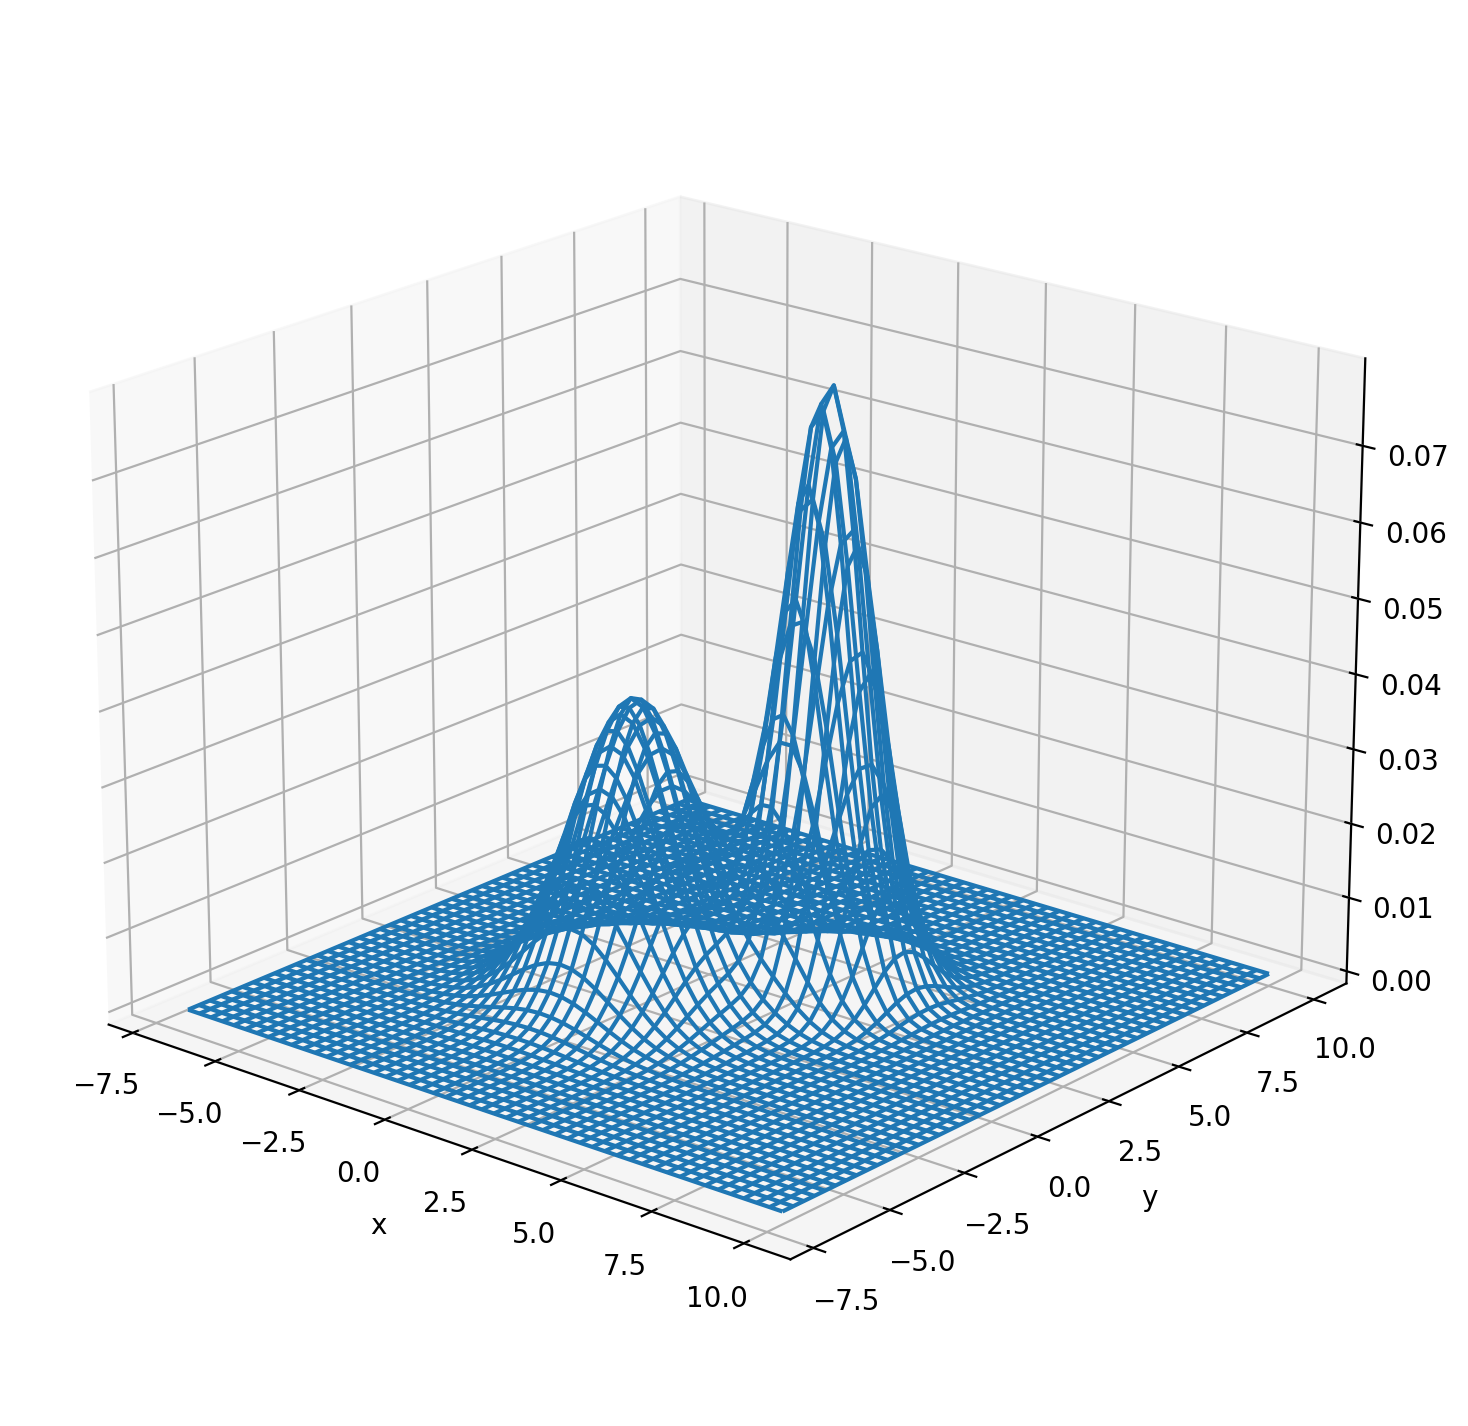

In [25]:
fig = plt.figure(figsize=(9,9), dpi=200)
ax = plt.axes(projection='3d')
ax.view_init(elev=20, azim=-50, roll=0)
w = ax.plot_wireframe(X_,Y_,Z_)
#ax.set_title("3D projection of the DGP Distribution")
ax.set_xlabel("x")
ax.set_ylabel("y")
#ax.set_zlabel("Distribution")
plt.savefig("3D Mixture.png")
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (60000,) and arg 5 with shape (2500,).

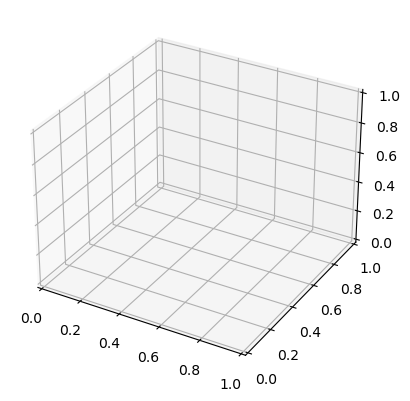

In [64]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

xdata = samples_large[:,0].numpy()
ydata = samples_large[:,1].numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

hist, xedges, yedges = np.histogram2d(xdata, ydata, bins=(50,50))

xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like(xpos)

dx = xedges[1]-xedges[0]
dy = yedges[1]-yedges[0]
dz = hist.flatten()

cmap = mpl.colormaps['jet']
max_height = np.max(dz)
min_height = np.min(dz)
rgba = [cmap((k-min_height)/max_height) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx,dy,dz, color=rgba, zsort='average')
plt.show()

In [70]:
a = torch.tensor([[5.,7.], [8.,9.], [1.,1.],[-3.,6.]])
b = torch.tensor([[0.,0.]])
torch.cat((a, torch.atleast_2d(b[0])), 0)

tensor([[ 5.,  7.],
        [ 8.,  9.],
        [ 1.,  1.],
        [-3.,  6.],
        [ 0.,  0.]])

In [27]:
X = np.linspace(-4,6, 100)
Y = np.linspace(-4,6,100)
X, Y = np.meshgrid(X,Y)
pos = np.dstack(X)
rv = stats.normal(4, 1)
rv2 = stats.normal(0, 2)
Z = rv.pdf(pos)
Z2 = rv2.pdf(pos)
trial = 0.5 * Z + 0.5 * Z2

AttributeError: module 'scipy.stats' has no attribute 'normal'

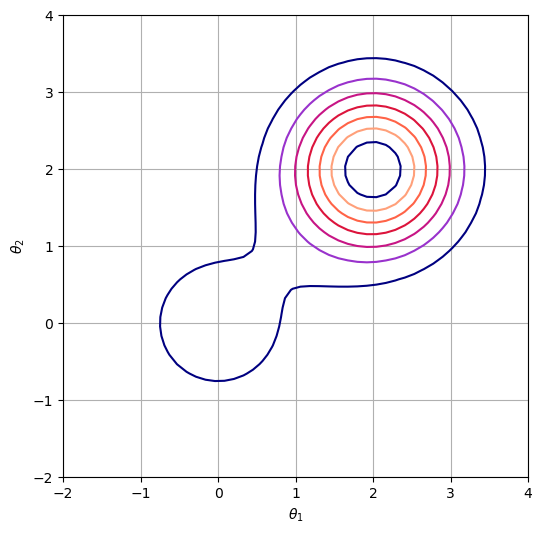

In [47]:
x = y = np.linspace(-2,4)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0.25, [2.,2.], .5, [0.,0.], 1., 2)

plt.figure(figsize=(6,6))
c1 = plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
h1,_ = c1.legend_elements()
plt.grid(visible=True)
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.savefig("DGP_#clients.png")
plt.show()

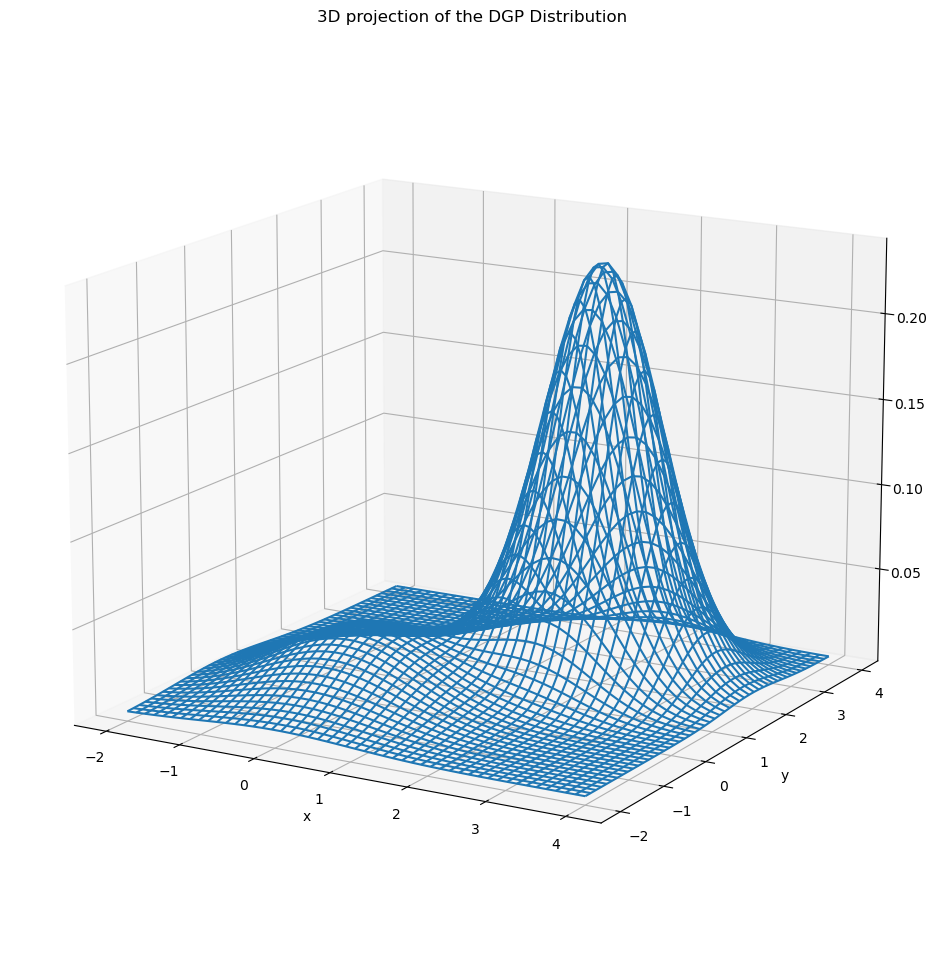

In [36]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.view_init(elev=15, azim=-60, roll=0)
w = ax.plot_wireframe(X_,Y_,Z_, )
ax.set_title("3D projection of the DGP Distribution")
ax.set_xlabel("x")
ax.set_ylabel("y")
#ax.set_zlabel("Distribution")
plt.show()

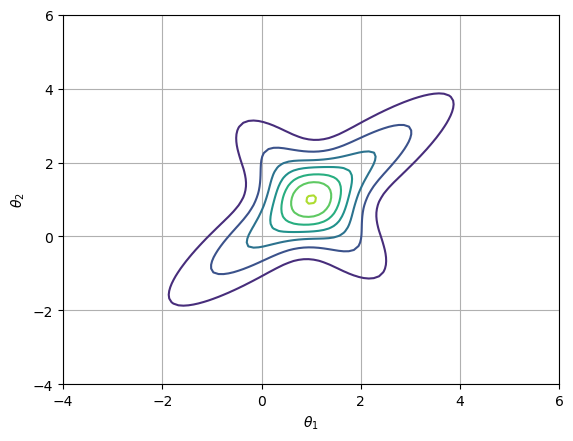

In [46]:
X = np.linspace(-4,6, 100)
Y = np.linspace(-4,6,100)
X, Y = np.meshgrid(X,Y)
pos = np.dstack((X,Y))
rv = multivariate_normal([1.,1.], [[3.,2.7],[2.7,3]])
rv2 = multivariate_normal([1.,1.], [[1.,-1.1],[-1.1,2.]])
Z = rv.pdf(pos)
Z2 = rv2.pdf(pos)
trial = 0.65 * Z + 0.35 * Z2
#plt.contour(X,Y,Z)
#plt.contour(X,Y,Z2, colors=cmap1)
plt.contour(X,Y,trial)
#Z_ = Gaussian.GaussianMixture([mean_1_gaus,mean_2_gaus], [var_1_gaus,var_2_gaus], torch.tensor(A), torch.tensor([.75,.25]))

#plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
#plt.scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=1)
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.grid(visible=True)
plt.savefig("Unimodal_cov_DGP.png")

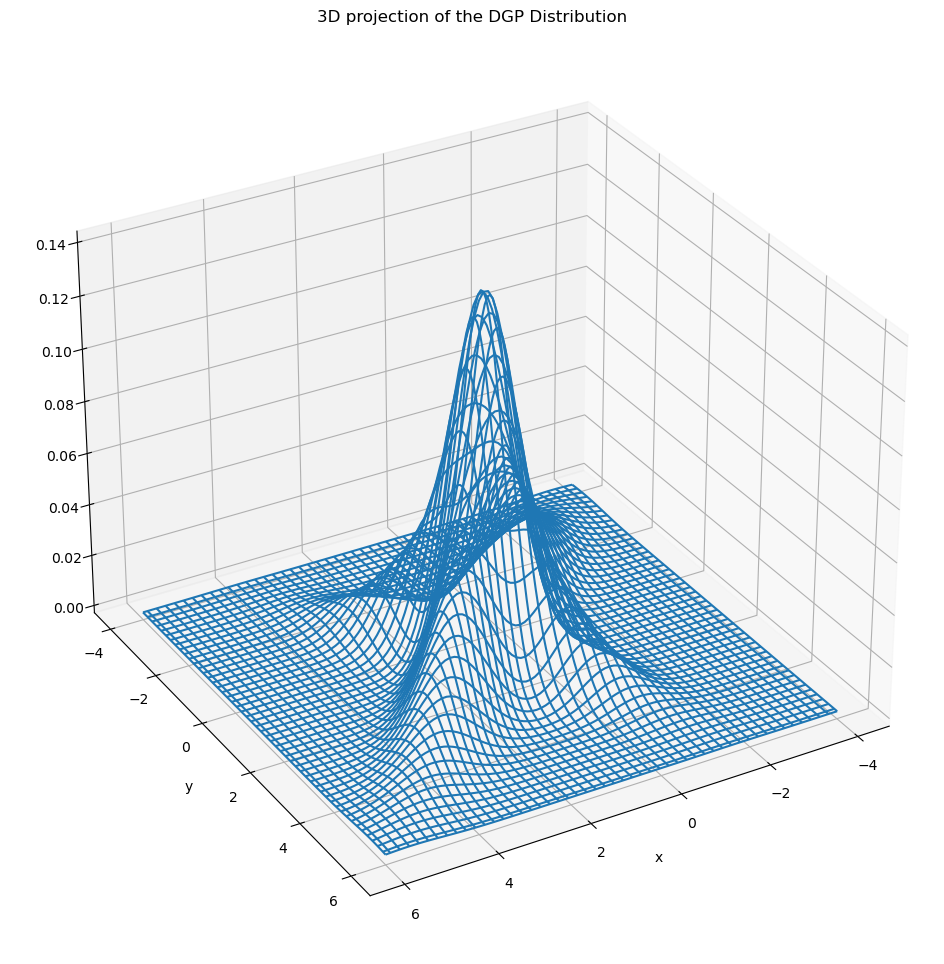

In [41]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.view_init(elev=30, azim=60, roll=0)
w = ax.plot_wireframe(X,Y,trial, )
ax.set_title("3D projection of the DGP Distribution")
ax.set_xlabel("x")
ax.set_ylabel("y")
#ax.set_zlabel("Distribution")
plt.show()

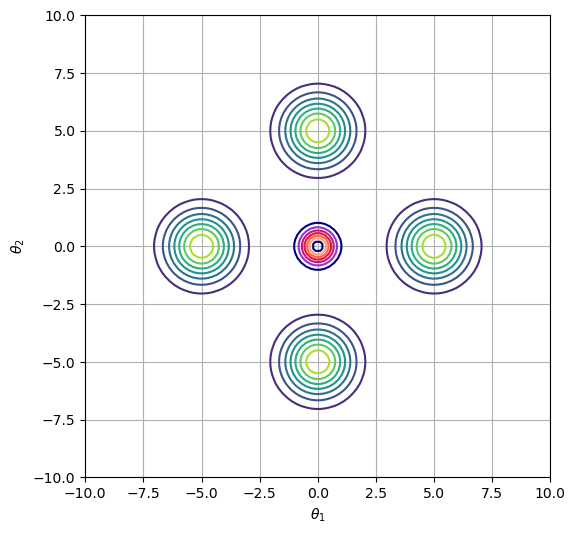

In [34]:
X = np.linspace(-10,10, 100)
Y = np.linspace(-10,10,100)
X, Y = np.meshgrid(X,Y)
pos = np.dstack((X,Y))
rv1 = multivariate_normal([5.,0.], [[1,0],[0.,1]])
rv2 = multivariate_normal([-5.,0.], [[1,0],[0.,1]])
rv3 = multivariate_normal([0.,5.], [[1,0],[0.,1]])
rv4 = multivariate_normal([0.,-5.], [[1,0],[0.,1]])
Z1 = rv1.pdf(pos)
Z2 = rv2.pdf(pos)
Z3 = rv3.pdf(pos)
Z4 = rv4.pdf(pos)

rv5 = multivariate_normal([0.,0.], [[10,0],[0.,10]])
Z5 = rv5.pdf(pos)
p = 0.25 * Z1 + 0.25 * Z2 + 0.25 * Z3 + 0.25 * Z4

q = Z1*Z2*Z3*Z4*Z5

plt.figure(figsize=(6,6))
#plt.contour(X,Y,Z)
#plt.contour(X,Y,Z2, colors=cmap1)
plt.contour(X,Y,p)
plt.contour(X,Y,q, colors=cmap1)
#plt.contour(X,Y,Z5)


#Z_ = Gaussian.GaussianMixture([mean_1_gaus,mean_2_gaus], [var_1_gaus,var_2_gaus], torch.tensor(A), torch.tensor([.75,.25]))

#plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
#plt.scatter(samples_gaus[:,0], samples_gaus[:,1], c="steelblue", alpha=1)
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.grid(visible=True)
#plt.savefig("Unimodal_cov_DGP.png")